In [3]:
"""This script is used to configure the collider from config file to model realistic conditions."""

# ==================================================================================================
# --- Imports
# ==================================================================================================
import json
import ruamel.yaml
from pathlib import Path
import numpy as np
import pandas as pd
import os
import xtrack as xt
import xmask as xm

import BBStudies
from  BBStudies.Tracking.Jobs.J001_configure_collider.job_specific_tools import generate_orbit_correction_setup,luminosity_leveling, luminosity_leveling_ip1_5, compute_PU
import BBStudies.Tracking.Jobs.J001_configure_collider.bbcw_utils as bbcw_utils
import BBStudies.Tracking.Utils as xutils



# ==================================================================================================
# --- Functions to generate configuration files for orbit correction
# ==================================================================================================

def generate_configuration_correction_files(output_folder="_correction"):
    # Generate configuration files for orbit correction
    correction_setup = generate_orbit_correction_setup()
    os.makedirs(output_folder, exist_ok=True)
    for nn in ["lhcb1", "lhcb2"]:
        with open(f"{output_folder}/corr_co_{nn}.json", "w") as fid:
            json.dump(correction_setup[nn], fid, indent=4)


# ==================================================================================================
# --- Function to install beam-beam
# ==================================================================================================
def install_beam_beam(collider, config_collider):
    # Load config
    config_bb = config_collider["config_beambeam"]

    # Install beam-beam lenses (inactive and not configured)
    collider.install_beambeam_interactions(
        clockwise_line="lhcb1",
        anticlockwise_line="lhcb2",
        ip_names=["ip1", "ip2", "ip5", "ip8"],
        delay_at_ips_slots=[0, 891, 0, 2670],
        num_long_range_encounters_per_side=config_bb["num_long_range_encounters_per_side"],
        num_slices_head_on=config_bb["num_slices_head_on"],
        harmonic_number=35640,
        bunch_spacing_buckets=config_bb["bunch_spacing_buckets"],
        sigmaz=config_bb["sigma_z"],
    )

    return collider, config_bb


# ==================================================================================================
# --- Function to match knobs and tuning
# ==================================================================================================
def set_knobs(config_collider, collider):
    # Read knobs and tuning settings from config file
    conf_knobs_and_tuning = config_collider["config_knobs_and_tuning"]

    # Set all knobs (crossing angles, dispersion correction, rf, crab cavities,
    # experimental magnets, etc.)
    for kk, vv in conf_knobs_and_tuning["knob_settings"].items():
        collider.vars[kk] = vv

    return collider, conf_knobs_and_tuning


def match_tune_and_chroma(collider, conf_knobs_and_tuning, match_linear_coupling_to_zero=True):
    # Tunings
    for line_name in ["lhcb1", "lhcb2"]:
        knob_names = conf_knobs_and_tuning["knob_names"][line_name]

        targets = {
            "qx": conf_knobs_and_tuning["qx"][line_name],
            "qy": conf_knobs_and_tuning["qy"][line_name],
            "dqx": conf_knobs_and_tuning["dqx"][line_name],
            "dqy": conf_knobs_and_tuning["dqy"][line_name],
        }

        xm.machine_tuning(
            line=collider[line_name],
            enable_closed_orbit_correction=True,
            enable_linear_coupling_correction=match_linear_coupling_to_zero,
            enable_tune_correction=True,
            enable_chromaticity_correction=True,
            knob_names=knob_names,
            targets=targets,
            line_co_ref=collider[line_name + "_co_ref"],
            co_corr_config=conf_knobs_and_tuning["closed_orbit_correction"][line_name],
        )

    return collider


# ==================================================================================================
# --- Function to compute the number of collisions in the IPs (used for luminosity leveling)
# ==================================================================================================
def compute_collision_from_scheme(pattern_fname):
    # # Get the filling scheme path (in json or csv format)
    # filling_scheme_path = config_bb["mask_with_filling_pattern"]["pattern_fname"]


    # Load the filling scheme
    if pattern_fname.endswith(".json"):
        with open(pattern_fname, "r") as fid:
            filling_scheme = json.load(fid)
    else:
        raise ValueError(
            f"Unknown filling scheme file format: {pattern_fname}. It you provided a csv"
            " file, it should have been automatically convert when running the script"
            " 001_make_folders.py. Something went wrong."
        )

    # Extract booleans beam arrays
    array_b1 = np.array(filling_scheme["beam1"])
    array_b2 = np.array(filling_scheme["beam2"])

    # Assert that the arrays have the required length, and do the convolution
    assert len(array_b1) == len(array_b2) == 3564
    n_collisions_ip1_and_5 = array_b1 @ array_b2
    n_collisions_ip2 = np.roll(array_b1, 891) @ array_b2
    n_collisions_ip8 = np.roll(array_b1, 2670) @ array_b2

    return n_collisions_ip1_and_5, n_collisions_ip2, n_collisions_ip8


# ==================================================================================================
# --- Function to do the Levelling
# ==================================================================================================
def do_levelling(
    config_collider, config_bb, n_collisions_ip2, n_collisions_ip8, collider, n_collisions_ip1_and_5
):
    # Read knobs and tuning settings from config file (already updated with the number of collisions)
    config_lumi_leveling = config_collider["config_lumi_leveling"]

    # Update the number of bunches in the configuration file
    config_lumi_leveling["ip2"]["num_colliding_bunches"] = int(n_collisions_ip2)
    config_lumi_leveling["ip8"]["num_colliding_bunches"] = int(n_collisions_ip8)

    # First level luminosity in IP 1/5 changing the intensity
    if "config_lumi_leveling_ip1_5" in config_collider:
        print("Leveling luminosity in IP 1/5 varying the intensity")
        # Update the number of bunches in the configuration file
        config_collider["config_lumi_leveling_ip1_5"]["num_colliding_bunches"] = int(
            n_collisions_ip1_and_5
        )

        # Get crab cavities
        crab = False
        if "on_crab1" in config_collider["config_knobs_and_tuning"]["knob_settings"]:
            crab_val = float(
                config_collider["config_knobs_and_tuning"]["knob_settings"]["on_crab1"]
            )
            if crab_val > 0:
                crab = True

        # Do the levelling
        try:
            I = luminosity_leveling_ip1_5(
                collider,
                config_collider,
                config_bb,
                crab=crab,
            )
        except ValueError:
            print("There was a problem during the luminosity leveling in IP1/5... Ignoring it.")
            I = config_bb["num_particles_per_bunch"]
            
        initial_I = config_bb["num_particles_per_bunch"]
        config_bb["num_particles_per_bunch"] = float(I)

    # Set up the constraints for lumi optimization in IP8
    additional_targets_lumi = []
    if "constraints" in config_lumi_leveling["ip8"]:
        for constraint in config_lumi_leveling["ip8"]["constraints"]:
            obs, beam, sign, val, at = constraint.split("_")
            target = xt.TargetInequality(obs, sign, float(val), at=at, line=beam, tol=1e-6)
            additional_targets_lumi.append(target)

    # Then level luminosity in IP 2/8 changing the separation
    collider = luminosity_leveling(
        collider,
        config_lumi_leveling=config_lumi_leveling,
        config_beambeam=config_bb,
        additional_targets_lumi=additional_targets_lumi,
        crab=crab,
    )

    # Update configuration
    config_bb["num_particles_per_bunch_before_optimization"] = float(initial_I)
    config_collider["config_lumi_leveling"]["ip2"]["final_on_sep2h"] = float(
        collider.vars["on_sep2h"]._value
    )
    config_collider["config_lumi_leveling"]["ip2"]["final_on_sep2v"] = float(
        collider.vars["on_sep2v"]._value
    )
    config_collider["config_lumi_leveling"]["ip8"]["final_on_sep8h"] = float(
        collider.vars["on_sep8h"]._value
    )
    config_collider["config_lumi_leveling"]["ip8"]["final_on_sep8v"] = float(
        collider.vars["on_sep8v"]._value
    )

    return collider, config_collider, crab


# ==================================================================================================
# --- Function to add linear coupling
# ==================================================================================================
def add_linear_coupling(conf_knobs_and_tuning, collider, config_mad):
    # Get the version of the optics
    version_hllhc = config_mad["ver_hllhc_optics"]
    version_run = config_mad["ver_lhc_run"]

    # Add linear coupling as the target in the tuning of the base collider was 0
    # (not possible to set it the target to 0.001 for now)
    if version_run == 3.0:
        collider.vars["cmrs.b1_sq"] += conf_knobs_and_tuning["delta_cmr"]
        collider.vars["cmrs.b2_sq"] += conf_knobs_and_tuning["delta_cmr"]
    elif version_hllhc == 1.6 or version_hllhc == 1.5:
        collider.vars["c_minus_re_b1"] += conf_knobs_and_tuning["delta_cmr"]
        collider.vars["c_minus_re_b2"] += conf_knobs_and_tuning["delta_cmr"]
    else:
        raise ValueError(f"Unknown version of the optics/run: {version_hllhc}, {version_run}.")

    return collider


# ==================================================================================================
# --- Function to assert that tune, chromaticity and linear coupling are correct before beam-beam
#     configuration
# ==================================================================================================
def assert_tune_chroma_coupling(collider, conf_knobs_and_tuning):
    for line_name in ["lhcb1", "lhcb2"]:
        tw = collider[line_name].twiss()
        assert np.isclose(tw.qx, conf_knobs_and_tuning["qx"][line_name], atol=1e-4), (
            f"tune_x is not correct for {line_name}. Expected"
            f" {conf_knobs_and_tuning['qx'][line_name]}, got {tw.qx}"
        )
        assert np.isclose(tw.qy, conf_knobs_and_tuning["qy"][line_name], atol=1e-4), (
            f"tune_y is not correct for {line_name}. Expected"
            f" {conf_knobs_and_tuning['qy'][line_name]}, got {tw.qy}"
        )
        assert np.isclose(
            tw.dqx,
            conf_knobs_and_tuning["dqx"][line_name],
            rtol=1e-2,
        ), (
            f"chromaticity_x is not correct for {line_name}. Expected"
            f" {conf_knobs_and_tuning['dqx'][line_name]}, got {tw.dqx}"
        )
        assert np.isclose(
            tw.dqy,
            conf_knobs_and_tuning["dqy"][line_name],
            rtol=1e-2,
        ), (
            f"chromaticity_y is not correct for {line_name}. Expected"
            f" {conf_knobs_and_tuning['dqy'][line_name]}, got {tw.dqy}"
        )

        assert np.isclose(
            tw.c_minus,
            conf_knobs_and_tuning["delta_cmr"],
            atol=5e-3,
        ), (
            f"linear coupling is not correct for {line_name}. Expected"
            f" {conf_knobs_and_tuning['delta_cmr']}, got {tw.c_minus}"
        )


# ==================================================================================================
# --- Function to configure beam-beam
# ==================================================================================================
def configure_beam_beam(collider, config_bb,pattern_fname = ''):
    collider.configure_beambeam_interactions(
        num_particles=config_bb["num_particles_per_bunch"],
        nemitt_x=config_bb["nemitt_x"],
        nemitt_y=config_bb["nemitt_y"],
    )

    # Configure filling scheme mask and bunch numbers
    if "mask_with_filling_pattern" in config_bb:
        # Initialize filling pattern with empty values
        filling_pattern_cw = None
        filling_pattern_acw = None

        # Initialize bunch numbers with empty values
        i_bunch_cw = None
        i_bunch_acw = None

        if pattern_fname != '' :
            # Fill values if possible
            with open(pattern_fname, "r") as fid:
                filling = json.load(fid)
            filling_pattern_cw = filling["beam1"]
            filling_pattern_acw = filling["beam2"]

            # Only track bunch number if a filling pattern has been provided
            if "i_bunch_b1" in config_bb["mask_with_filling_pattern"]:
                i_bunch_cw = config_bb["mask_with_filling_pattern"]["i_bunch_b1"]
            if "i_bunch_b2" in config_bb["mask_with_filling_pattern"]:
                i_bunch_acw = config_bb["mask_with_filling_pattern"]["i_bunch_b2"]

            # Note that a bunch number must be provided if a filling pattern is provided
            # Apply filling pattern
            collider.apply_filling_pattern(
                filling_pattern_cw=filling_pattern_cw,
                filling_pattern_acw=filling_pattern_acw,
                i_bunch_cw=i_bunch_cw,
                i_bunch_acw=i_bunch_acw,
            )
    return collider


# ==================================================================================================
# --- Function to compute luminosity once the collider is configured
# ==================================================================================================
def record_final_luminosity(collider, config_collider, l_n_collisions, crab):
    
    config_bb = config_collider["config_beambeam"]

    # Get the final luminoisty in all IPs
    twiss_b1 = collider["lhcb1"].twiss()
    twiss_b2 = collider["lhcb2"].twiss()
    l_lumi = []
    l_PU = []
    l_ip = ["ip1", "ip2", "ip5", "ip8"]
    for n_col, ip in zip(l_n_collisions, l_ip):
        try:
            L = xt.lumi.luminosity_from_twiss(
                    n_colliding_bunches=n_col,
                    num_particles_per_bunch=config_bb["num_particles_per_bunch"],
                    ip_name=ip,
                    nemitt_x=config_bb["nemitt_x"],
                    nemitt_y=config_bb["nemitt_y"],
                    sigma_z=config_bb["sigma_z"],
                    twiss_b1=twiss_b1,
                    twiss_b2=twiss_b2,
                    crab=crab,
                )
            PU = compute_PU(L, n_col, twiss_b1["T_rev0"])
        except:
            print(f"There was a problem during the luminosity computation in {ip}... Ignoring it.")
            L = 0
            PU = 0
        l_lumi.append(L)
        l_PU.append(PU)

    # Update configuration
    for ip, L, PU in zip(l_ip, l_lumi, l_PU):
        config_collider["config_beambeam"][f"luminosity_{ip}_after_optimization"] = float(L)
        config_collider["config_beambeam"][f"Pile-up_{ip}_after_optimization"] = float(PU)
        
    return config_collider



class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

def save_collider(_collider,_config,file_path,include_config=False):
    if include_config:
        collider_dict = _collider.to_dict()
        collider_dict["config_yaml"] = _config

        #  collider.set_metadata(config_dict)
        with open(file_path, "w") as fid:
            json.dump(collider_dict, fid, cls=NpEncoder)
        
    else:
        collider.to_json(file_path)


# ==================================================================================================
# --- Main function for collider configuration
# ==================================================================================================
def configure_collider(config_file = 'config.yaml'):
    
    
    # Generate configuration files for orbit correction
    #-------------------
    generate_configuration_correction_files()
    #-------------------


    # Loading collider and configs
    #-------------------
    config      = xutils.read_YAML(file=config_file )
    collider    = xt.Multiline.from_json(config['from_collider'])
    config_mad  = collider.metadata['config_J000']
    config_collider = config["config_collider"]
    #-------------------


    # Preparing output folder
    #-------------------
    save_collider = config["save_collider"]

    if save_collider is not None:
        xutils.mkdir(save_collider)
    #-------------------

    # Finding Filling scheme
    #-------------------
    pattern_fname = config_collider['config_beambeam']['mask_with_filling_pattern']['pattern_fname']
    if not Path(pattern_fname).exists():
        pattern_fname = str(Path(BBStudies.__file__).parents[1]/pattern_fname)
    #-------------------
        
    # Install BBCW
    collider = bbcw_utils.install_BBCW(collider,L_phy=1,L_int=2)

    # Install beam-beam
    collider, config_bb = install_beam_beam(collider, config_collider)

    # Build trackers
    collider.build_trackers()

    # Set knobs
    collider, conf_knobs_and_tuning = set_knobs(config_collider, collider)

    # Match tune and chromaticity
    collider = match_tune_and_chroma(
        collider, conf_knobs_and_tuning, match_linear_coupling_to_zero=True
    )

    # Compute the number of collisions in the different IPs
    (
        n_collisions_ip1_and_5,
        n_collisions_ip2,
        n_collisions_ip8,
    ) = compute_collision_from_scheme(pattern_fname)

    # Do the leveling if requested
    if "config_lumi_leveling" in config_collider and not config_collider["skip_leveling"]:
        collider, config_collider, crab = do_levelling(
            config_collider,
            config_bb,
            n_collisions_ip2,
            n_collisions_ip8,
            collider,
            n_collisions_ip1_and_5,
        )
    else:
        print(
            "No leveling is done as no configuration has been provided, or skip_leveling"
            " is set to True."
        )

        # Get crab cavities
        crab = False
        if "on_crab1" in config_collider["config_knobs_and_tuning"]["knob_settings"]:
            crab_val = float(
                config_collider["config_knobs_and_tuning"]["knob_settings"]["on_crab1"]
            )
            if crab_val > 0:
                crab = True

    # Add linear coupling
    collider = add_linear_coupling(conf_knobs_and_tuning, collider, config_mad)

    # Rematch tune and chromaticity
    collider = match_tune_and_chroma(
        collider, conf_knobs_and_tuning, match_linear_coupling_to_zero=False
    )

    # Assert that tune, chromaticity and linear coupling are correct one last time
    assert_tune_chroma_coupling(collider, conf_knobs_and_tuning)



    activate_beam_beam = config_collider['config_beambeam']['activate_beam_beam']
    if activate_beam_beam:
        # Configure beam-beam
        collider = configure_beam_beam(collider, config_bb,pattern_fname=pattern_fname)


    # Power BBCW
    collider,qff_knobs = bbcw_utils.power_BBCW(collider,config)
    collider.metadata['qff_knobs'] = qff_knobs


    # Update configuration with luminosity now that bb is known
    l_n_collisions  = [n_collisions_ip1_and_5, n_collisions_ip2, n_collisions_ip1_and_5, n_collisions_ip8]
    config_collider = record_final_luminosity(collider,config_collider, l_n_collisions, crab)
    config['config_collider'] = config_collider


    # Saving resulting collider
    if save_collider is not None:
        # Save the final collider before tracking
        print(f'Saving "{save_collider}"')

        # Saving config in metadata
        collider.metadata['config_J001'] = config
        collider.to_json(save_collider)




    # Remove the correction folder, and potential C files remaining
    try:
        os.system("rm -rf _correction")
        os.system("rm -f *.cc")
    except:
        pass

    print('Job Finished!')
    return collider





config_file = '/Users/pbelanger/ABPLocal/BBStudies/examples/run_xmask_jobs_prebaked/configs/tmp_config_J001_0.yaml'



---
# RUN HERE
---

In [5]:

# Generate configuration files for orbit correction
#-------------------
generate_configuration_correction_files()
#-------------------


# Loading collider and configs
#-------------------
config      = xutils.read_YAML(file=config_file )
config['from_collider'] = '/Users/pbelanger/ABPLocal/BBStudies/examples/run_xmask_jobs_prebaked/colliders/collider_000.json'
collider    = xt.Multiline.from_json(config['from_collider'])
config_mad  = collider.metadata['config_J000']
config_collider = config["config_collider"]
#-------------------


# Preparing output folder
#-------------------
save_collider = config["save_collider"]

if save_collider is not None:
    xutils.mkdir(save_collider)
#-------------------

# Finding Filling scheme
#-------------------
pattern_fname = config_collider['config_beambeam']['mask_with_filling_pattern']['pattern_fname']
if not Path(pattern_fname).exists():
    pattern_fname = str(Path(BBStudies.__file__).parents[1]/pattern_fname)
#-------------------
    
# Install BBCW
collider = bbcw_utils.install_BBCW(collider,L_phy=1,L_int=2)

# Install beam-beam
collider, config_bb = install_beam_beam(collider, config_collider)

# Build trackers
collider.build_trackers()

# Set knobs
collider, conf_knobs_and_tuning = set_knobs(config_collider, collider)

# Match tune and chromaticity
collider = match_tune_and_chroma(
    collider, conf_knobs_and_tuning, match_linear_coupling_to_zero=True
)

# Compute the number of collisions in the different IPs
(
    n_collisions_ip1_and_5,
    n_collisions_ip2,
    n_collisions_ip8,
) = compute_collision_from_scheme(pattern_fname)

# Do the leveling if requested
if "config_lumi_leveling" in config_collider and not config_collider["skip_leveling"]:
    collider, config_collider, crab = do_levelling(
        config_collider,
        config_bb,
        n_collisions_ip2,
        n_collisions_ip8,
        collider,
        n_collisions_ip1_and_5,
    )
else:
    print(
        "No leveling is done as no configuration has been provided, or skip_leveling"
        " is set to True."
    )

    # Get crab cavities
    crab = False
    if "on_crab1" in config_collider["config_knobs_and_tuning"]["knob_settings"]:
        crab_val = float(
            config_collider["config_knobs_and_tuning"]["knob_settings"]["on_crab1"]
        )
        if crab_val > 0:
            crab = True

# Add linear coupling
collider = add_linear_coupling(conf_knobs_and_tuning, collider, config_mad)

# Rematch tune and chromaticity
collider = match_tune_and_chroma(
    collider, conf_knobs_and_tuning, match_linear_coupling_to_zero=False
)

# Assert that tune, chromaticity and linear coupling are correct one last time
assert_tune_chroma_coupling(collider, conf_knobs_and_tuning)



activate_beam_beam = config_collider['config_beambeam']['activate_beam_beam']
if activate_beam_beam:
    # Configure beam-beam
    collider = configure_beam_beam(collider, config_bb,pattern_fname=pattern_fname)


# Power BBCW
collider,qff_knobs = bbcw_utils.power_BBCW(collider,config)
collider.metadata['qff_knobs'] = qff_knobs


# Update configuration with luminosity now that bb is known
l_n_collisions  = [n_collisions_ip1_and_5, n_collisions_ip2, n_collisions_ip1_and_5, n_collisions_ip8]
config_collider = record_final_luminosity(collider,config_collider, l_n_collisions, crab)
config['config_collider'] = config_collider


# Saving resulting collider
if save_collider is not None:
    # Save the final collider before tracking
    print(f'Saving "{save_collider}"')

    # Saving config in metadata
    collider.metadata['config_J001'] = config
    collider.to_json(save_collider)




# Remove the correction folder, and potential C files remaining
try:
    os.system("rm -rf _correction")
    os.system("rm -f *.cc")
except:
    pass

print('Job Finished!')
# return collider


Loading line from dict:   0%|          | 0/80692 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/80836 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/80692 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/80836 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...


692930090b6b4965b76200d2f18ebdd0.c:5366:11: warning: '_GNU_SOURCE' macro redefined [-Wmacro-redefined]
#  define _GNU_SOURCE // enable GNU libc NAN extension if possible
          ^
/Users/pbelanger/ABPLocal/BBStudies/Executables/miniforge3/envs/py-BB/include/python3.10/pyconfig.h:1621:9: note: previous definition is here
#define _GNU_SOURCE 1
        ^
692930090b6b4965b76200d2f18ebdd0.c:18591:12: warning: variable 'gamma' set but not used [-Wunused-but-set-variable]
    double gamma          = energy / m0;     // [1]
           ^
692930090b6b4965b76200d2f18ebdd0.c:18859:9: warning: variable 'i' set but not used [-Wunused-but-set-variable]
    int i=0;
        ^
692930090b6b4965b76200d2f18ebdd0.c:18948:62: warning: variable 'ps_e_prime' set but not used [-Wunused-but-set-variable]
    double e_e_prime, px_e_prime, py_e_prime, pzeta_e_prime, ps_e_prime, pt_e_prime;  // [GeV, 1, 1, 1, 1, 1] scattered primary
                                                             ^
692930090b6b4965b

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


71d078a909e94a12b58fc73a5b9659c1.c:5366:11: warning: '_GNU_SOURCE' macro redefined [-Wmacro-redefined]
#  define _GNU_SOURCE // enable GNU libc NAN extension if possible
          ^
/Users/pbelanger/ABPLocal/BBStudies/Executables/miniforge3/envs/py-BB/include/python3.10/pyconfig.h:1621:9: note: previous definition is here
#define _GNU_SOURCE 1
        ^
71d078a909e94a12b58fc73a5b9659c1.c:18591:12: warning: variable 'gamma' set but not used [-Wunused-but-set-variable]
    double gamma          = energy / m0;     // [1]
           ^
71d078a909e94a12b58fc73a5b9659c1.c:18859:9: warning: variable 'i' set but not used [-Wunused-but-set-variable]
    int i=0;
        ^
71d078a909e94a12b58fc73a5b9659c1.c:18948:62: warning: variable 'ps_e_prime' set but not used [-Wunused-but-set-variable]
    double e_e_prime, px_e_prime, py_e_prime, pzeta_e_prime, ps_e_prime, pt_e_prime;  // [GeV, 1, 1, 1, 1, 1] scattered primary
                                                             ^
71d078a909e94a12b

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Correcting closed orbit
Correcting IR1 left
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Matching: model call n. 6               

Correcting IR1 right
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Matching: model call n. 6               

Correcting IR5 left
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Matching: model call n. 6               

Correcting IR5 right
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Matching: model call n. 6               

Correcting IP1
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Matching: model call n. 1               

Correcting IP2
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Matching: model 

b786dcb11d4242d6b5d5623834a1e09e.c:5371:11: warning: '_GNU_SOURCE' macro redefined [-Wmacro-redefined]
#  define _GNU_SOURCE // enable GNU libc NAN extension if possible
          ^
/Users/pbelanger/ABPLocal/BBStudies/Executables/miniforge3/envs/py-BB/include/python3.10/pyconfig.h:1621:9: note: previous definition is here
#define _GNU_SOURCE 1
        ^
b786dcb11d4242d6b5d5623834a1e09e.c:18596:12: warning: variable 'gamma' set but not used [-Wunused-but-set-variable]
    double gamma          = energy / m0;     // [1]
           ^
b786dcb11d4242d6b5d5623834a1e09e.c:18864:9: warning: variable 'i' set but not used [-Wunused-but-set-variable]
    int i=0;
        ^
b786dcb11d4242d6b5d5623834a1e09e.c:18953:62: warning: variable 'ps_e_prime' set but not used [-Wunused-but-set-variable]
    double e_e_prime, px_e_prime, py_e_prime, pzeta_e_prime, ps_e_prime, pt_e_prime;  // [GeV, 1, 1, 1, 1, 1] scattered primary
                                                             ^
b786dcb11d4242d6b

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


9956b387c7ad4cb88099145fcf106a5f.c:5371:11: warning: '_GNU_SOURCE' macro redefined [-Wmacro-redefined]
#  define _GNU_SOURCE // enable GNU libc NAN extension if possible
          ^
/Users/pbelanger/ABPLocal/BBStudies/Executables/miniforge3/envs/py-BB/include/python3.10/pyconfig.h:1621:9: note: previous definition is here
#define _GNU_SOURCE 1
        ^
9956b387c7ad4cb88099145fcf106a5f.c:18596:12: warning: variable 'gamma' set but not used [-Wunused-but-set-variable]
    double gamma          = energy / m0;     // [1]
           ^
9956b387c7ad4cb88099145fcf106a5f.c:18864:9: warning: variable 'i' set but not used [-Wunused-but-set-variable]
    int i=0;
        ^
9956b387c7ad4cb88099145fcf106a5f.c:18953:62: warning: variable 'ps_e_prime' set but not used [-Wunused-but-set-variable]
    double e_e_prime, px_e_prime, py_e_prime, pzeta_e_prime, ps_e_prime, pt_e_prime;  // [GeV, 1, 1, 1, 1, 1] scattered primary
                                                             ^
9956b387c7ad4cb88

Done compiling ContextCpu kernels.
bb_lr.l1b1_17 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_18 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_19 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_20 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_21 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_22 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_23 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_24 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_25 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l5b1_17 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l5b1_18 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l5b1_19 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l5b1_20 Ref

76bf8498db454ab2ae934d68bbf1cb78.c:3946:11: warning: '_GNU_SOURCE' macro redefined [-Wmacro-redefined]
#  define _GNU_SOURCE // enable GNU libc NAN extension if possible
          ^
/Users/pbelanger/ABPLocal/BBStudies/Executables/miniforge3/envs/py-BB/include/python3.10/pyconfig.h:1621:9: note: previous definition is here
#define _GNU_SOURCE 1
        ^
1 warning generated.


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


86d3a53d47244751b0cf4183929463cb.c:7632:11: warning: '_GNU_SOURCE' macro redefined [-Wmacro-redefined]
#  define _GNU_SOURCE // enable GNU libc NAN extension if possible
          ^
/Users/pbelanger/ABPLocal/BBStudies/Executables/miniforge3/envs/py-BB/include/python3.10/pyconfig.h:1621:9: note: previous definition is here
#define _GNU_SOURCE 1
        ^
86d3a53d47244751b0cf4183929463cb.c:10662:12: warning: variable 'gamma' set but not used [-Wunused-but-set-variable]
    double gamma          = energy / m0;     // [1]
           ^
86d3a53d47244751b0cf4183929463cb.c:10930:9: warning: variable 'i' set but not used [-Wunused-but-set-variable]
    int i=0;
        ^
86d3a53d47244751b0cf4183929463cb.c:11019:62: warning: variable 'ps_e_prime' set but not used [-Wunused-but-set-variable]
    double e_e_prime, px_e_prime, py_e_prime, pzeta_e_prime, ps_e_prime, pt_e_prime;  // [GeV, 1, 1, 1, 1, 1] scattered primary
                                                             ^
86d3a53d47244751b

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


FileNotFoundError: [Errno 2] No such file or directory: 'colliders/collider_BBCW_BUNCH_0000.json'

In [6]:

bbcw_insert = {}
bbcw_insert['b1'] = {   'bbcw.t.4l1.b1':'tctpv.4l1.b1',
                        'bbcw.b.4l1.b1':'tctpv.4l1.b1',
                        'bbcw.e.4l5.b1':'tctph.4l5.b1',
                        'bbcw.i.4l5.b1':'tctph.4l5.b1'}
bbcw_insert['b2'] = {   'bbcw.t.4r1.b2':'tctpv.4r1.b2',
                        'bbcw.b.4r1.b2':'tctpv.4r1.b2',
                        'bbcw.e.4r5.b2':'tctph.4r5.b2',
                        'bbcw.i.4r5.b2':'tctph.4r5.b2'}

bbcw_xy = lambda _name: {   't':( 0, 1),
                            'b':( 0,-1),
                            'e':( 1, 0),
                            'i':(-1, 0)}[_name.split('.')[1]]

config_bbcw = config['config_collider']['config_bbcw']

# If the Q4 strenghts are forced load the file
#=========
if config_bbcw['qff_file'] is not None:
    force_knobs = xutils.read_metadata('/Users/pbelanger/ABPLocal/BBStudies/examples/run_xmask_jobs_prebaked/colliders/collider_BBCW_BUNCH_0000.json')['qff_knobs']
else:
    force_knobs = {}
#=========
    
    
qff_knobs = {}
for beam_name in ['b1','b2']:
    wire_dict = config_bbcw[f'{beam_name}'] 
    
    # Aligning the wires:
    #--------------------------------
    line    = collider[f'lhc{beam_name}']
    tw0     = line.twiss()
    target_co = []
    for _bbcw,_at in bbcw_insert[beam_name].items():
        ip      = 'ip' + _bbcw.split('.')[2][-1]
        tw_tct  = tw0.rows[_at]

        # updating knobs
        collider.vars[f'd_wire_{ip}.{beam_name}']    = wire_dict[ip]['distance']
        collider.vars[f'co_x_wire_{ip}.{beam_name}'] = tw_tct.x
        collider.vars[f'co_y_wire_{ip}.{beam_name}'] = tw_tct.y
        target_co.append(xt.TargetSet(  x = tw_tct.x[0],
                                        y = tw_tct.y[0], at=_at, tol=1e-6,tag=f'co_wire_{ip}'))
        

    # Preparing the matcher
    #--------------------------------
    # common_targets = target_co + [  xt.TargetSet(qx=tw0.qx, qy=tw0.qy, tol=1e-6, tag='tune'),
    #                                 xt.TargetSet(betx=tw0.rows['ip1'].betx[0], bety=tw0.rows['ip1'].bety[0],at='ip1', tol=1e-6, tag='betstar_ip1'),
    #                                 xt.TargetSet(betx=tw0.rows['ip5'].betx[0], bety=tw0.rows['ip5'].bety[0],at='ip5', tol=1e-6, tag='betstar_ip5')]
    
    common_targets = target_co + [  xt.TargetSet(qx=tw0.qx, qy=tw0.qy, tol=1e-6, tag='tune') ]
    opt = {}
    for ip in ['ip1','ip5']:
        opt[ip] = line.match(solve=False,
                                vary    = [ xt.VaryList([f'kq4.l{ip[-1]}{beam_name}', f'kq4.r{ip[-1]}{beam_name}'], step=1e-8, tag=f'quad_{ip}'),
                                            xt.VaryList([f'kq4.l{ip[-1]}{beam_name}.k0', f'kq4.r{ip[-1]}{beam_name}.k0'], step=1e-8, tag=f'quad_k0_{ip}')],
                                targets = common_targets)
       

In [7]:
force_knobs

{'b1': {'ip1': {'kq4.l1b1': 0.0034633753717085163,
   'kq4.r1b1': -0.003492374344418087,
   'kq4.l1b1.k0': 7.740509632238432e-09,
   'kq4.r1b1.k0': -9.50021401586889e-09},
  'ip5': {'kq4.l5b1': 0.0034985486075791087,
   'kq4.r5b1': -0.003482994446485442,
   'kq4.l5b1.k0': 1.8755415788367523e-08,
   'kq4.r5b1.k0': -1.2555403191009136e-09}},
 'b2': {'ip1': {'kq4.l1b2': -0.0033919942551812097,
   'kq4.r1b2': 0.003363005516348248,
   'kq4.l1b2.k0': -9.559907010413206e-09,
   'kq4.r1b2.k0': 7.518056274382011e-09},
  'ip5': {'kq4.l5b2': -0.0033826100521002767,
   'kq4.r5b2': 0.0033981592557351787,
   'kq4.l5b2.k0': 1.247842928661866e-09,
   'kq4.r5b2.k0': -1.8869304151439038e-08}}}

In [17]:
opt['ip1'].vary_status()
display(opt['ip1'].get_knob_values())

Vary status:                 
id state tag         name        lower_limit  current_val upper_limit val_at_iter_0  step weight
 0 ON    quad_ip1    kq4.l1b2           None  -0.00339199        None   -0.00338572 1e-08      1
 1 ON    quad_ip1    kq4.r1b2           None   0.00336301        None    0.00338572 1e-08      1
 2 ON    quad_k0_ip1 kq4.l1b2.k0        None -9.55991e-09        None             0 1e-08      1
 3 ON    quad_k0_ip1 kq4.r1b2.k0        None  7.51806e-09        None             0 1e-08      1


{'kq4.l1b2': -0.00338572138643,
 'kq4.r1b2': 0.00338572138643,
 'kq4.l1b2.k0': 0,
 'kq4.r1b2.k0': 0}

In [25]:
opt['ip1']._vary_table

<bound method Optimize._vary_table of <xdeps.optimize.optimize.Optimize object at 0x28826a980>>

In [29]:
opt['ip1']._err()

array([ 7.22905776e-08,  3.14749540e-08,  7.22905776e-08,  3.14749540e-08,
       -7.63681842e-08, -1.85979365e-08, -7.63681842e-08, -1.85979365e-08,
       -5.73545828e-02,  3.29537839e-02])

In [34]:
{v.name:collider.vars[v.name]._value for v in opt['ip1'].vary}

{'kq4.l1b2': -0.0033919942551812097,
 'kq4.r1b2': 0.003363005516348248,
 'kq4.l1b2.k0': -9.559907010413206e-09,
 'kq4.r1b2.k0': 7.518056274382011e-09}

In [35]:
{'ip1':{v.name:collider.vars[v.name]._value for v in opt['ip1'].vary}, 
                                'ip5':{v.name:collider.vars[v.name]._value for v in opt['ip5'].vary}}

{'ip1': {'kq4.l1b2': -0.0033919942551812097,
  'kq4.r1b2': 0.003363005516348248,
  'kq4.l1b2.k0': -9.559907010413206e-09,
  'kq4.r1b2.k0': 7.518056274382011e-09},
 'ip5': {'kq4.l5b2': -0.0033826100521002767,
  'kq4.r5b2': 0.0033981592557351787,
  'kq4.l5b2.k0': 1.247842928661866e-09,
  'kq4.r5b2.k0': -1.8869304151439038e-08}}

In [14]:
for ip in ['ip1','ip5']:

    # collider.vars[f'i_wire_{ip}.{beam_name}'] = wire_dict[ip]['current']

    # # assert no change on closed orbit
    # ttt = opt[ip].target_status(ret=True)
    # assert np.all(ttt['tol_met'][[('co_wire' in t) for t in ttt['tag']]]), 'Wires seems misaligned!'

    
    if config_bbcw['qff_file'] is not None:
        # If the Q4 strenghts are forced set the values
        #---------
        for _knob,_value in force_knobs[beam_name][ip].items():
            collider.vars[_knob] = _value
            # print(_knob,_value)
        #---------
        # Reading the knob values if
        opt[ip].vary_status()

Vary status:                 
id state tag         name        lower_limit  current_val upper_limit val_at_iter_0  step weight
 0 ON    quad_ip1    kq4.l1b2           None  -0.00339199        None   -0.00338572 1e-08      1
 1 ON    quad_ip1    kq4.r1b2           None   0.00336301        None    0.00338572 1e-08      1
 2 ON    quad_k0_ip1 kq4.l1b2.k0        None -9.55991e-09        None             0 1e-08      1
 3 ON    quad_k0_ip1 kq4.r1b2.k0        None  7.51806e-09        None             0 1e-08      1
Vary status:                 
id state tag         name        lower_limit  current_val upper_limit val_at_iter_0  step weight
 0 ON    quad_ip5    kq4.l5b2           None  -0.00338261        None   -0.00338572 1e-08      1
 1 ON    quad_ip5    kq4.r5b2           None   0.00339816        None    0.00338572 1e-08      1
 2 ON    quad_k0_ip5 kq4.l5b2.k0        None  1.24784e-09        None             0 1e-08      1
 3 ON    quad_k0_ip5 kq4.r5b2.k0        None -1.88693e-08        No

In [8]:
{'ip1':opt['ip1'].get_knob_values(), 'ip5':opt['ip5'].get_knob_values()}

{'ip1': {'kq4.l1b2': -0.00338572138643,
  'kq4.r1b2': 0.00338572138643,
  'kq4.l1b2.k0': 0,
  'kq4.r1b2.k0': 0},
 'ip5': {'kq4.l5b2': -0.00338572138643,
  'kq4.r5b2': 0.00338572138643,
  'kq4.l5b2.k0': 0,
  'kq4.r5b2.k0': 0}}

 
BEFORE WIRES


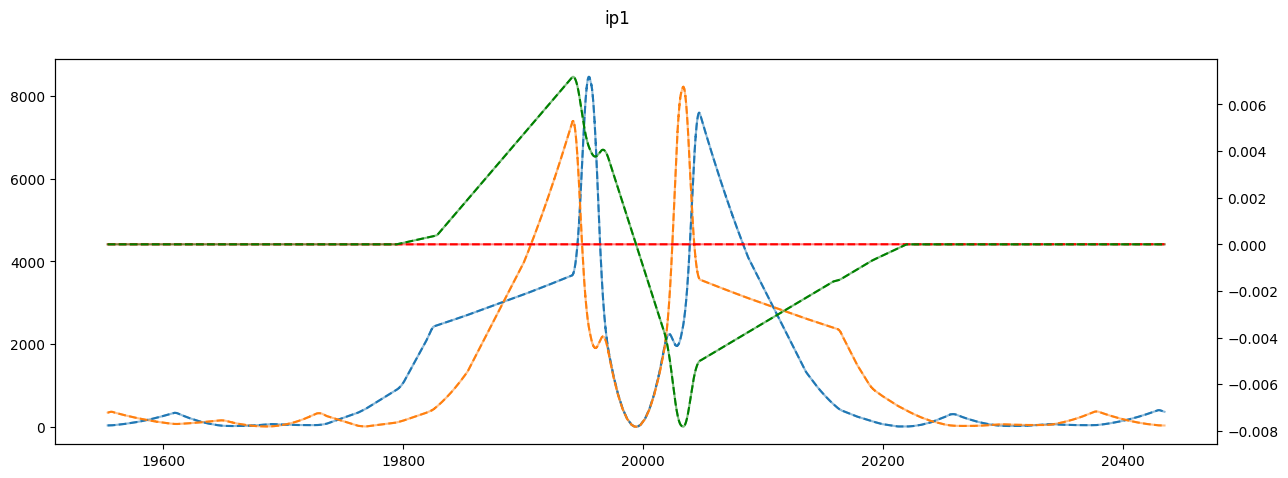

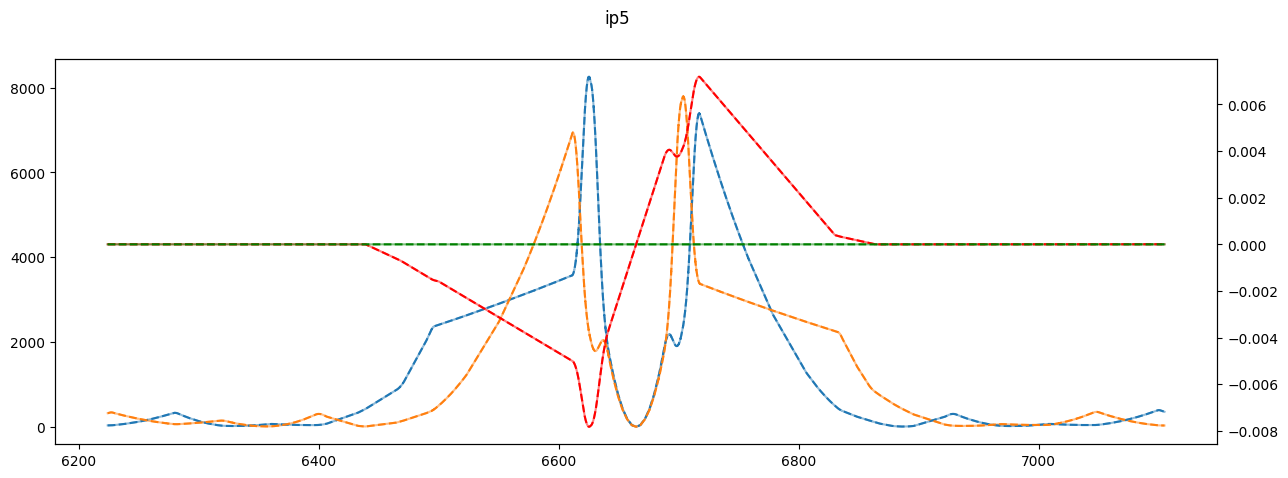

In [3]:
import matplotlib.pyplot as plt
if tw0 is None:
    line    = collider['lhcb1']
    tw0     = line.twiss()

    tw0_ip1 = tw0.rows['e.arc.81.b1':'s.arc.12.b1']
    tw0_ip5 = tw0.rows['e.arc.45.b1':'s.arc.56.b1']
    

    
tw     = line.twiss()
tw_ip1 = tw.rows['e.arc.81.b1':'s.arc.12.b1']
tw_ip5 = tw.rows['e.arc.45.b1':'s.arc.56.b1']
print(' ')
print('BEFORE WIRES')
for _tw,_tw0,name in zip([tw_ip1,tw_ip5],[tw0_ip1,tw0_ip5],['ip1','ip5']):

    plt.figure(figsize=(15,5))
    plt.suptitle(name)
    plt.plot(_tw0.s, _tw0.betx,ls = '-',alpha=0.5,color='C0', label='betx')
    plt.plot(_tw0.s, _tw0.bety,ls = '-',alpha=0.5,color='C1', label='bety')
    plt.plot(_tw.s, _tw.betx,ls ='--',color='C0', label='betx')
    plt.plot(_tw.s, _tw.bety,ls ='--',color='C1', label='bety')
    plt.twinx()
    plt.plot(_tw0.s, _tw0.x,ls = '-',alpha=0.5,color='r', label='betx')
    plt.plot(_tw0.s, _tw0.y,ls = '-',alpha=0.5,color='g', label='bety')
    plt.plot(_tw.s, _tw.x,ls ='--',color='r', label='betx')
    plt.plot(_tw.s, _tw.y,ls ='--',color='g', label='bety')


Target status:                          
id state tag         tol_met     residue  current_val   target_val description                                 
 0 ON    co_wire_ip1    True 1.04685e-13  4.98298e-07  4.98298e-07 line=lhcb1, ('x', 'tctpv.4l1.b1'), val=4 ...
 1 ON    co_wire_ip1    True 5.23646e-14    0.0015875    0.0015875 line=lhcb1, ('y', 'tctpv.4l1.b1'), val=0 ...
 2 ON    co_wire_ip1    True 1.04685e-13  4.98298e-07  4.98298e-07 line=lhcb1, ('x', 'tctpv.4l1.b1'), val=4 ...
 3 ON    co_wire_ip1    True 5.23646e-14    0.0015875    0.0015875 line=lhcb1, ('y', 'tctpv.4l1.b1'), val=0 ...
 4 ON    co_wire_ip5    True 9.05092e-15  -0.00209608  -0.00209608 line=lhcb1, ('x', 'tctph.4l5.b1'), val=- ...
 5 ON    co_wire_ip5    True 3.23102e-14 -3.19466e-07 -3.19466e-07 line=lhcb1, ('y', 'tctph.4l5.b1'), val=- ...
 6 ON    co_wire_ip5    True 9.05092e-15  -0.00209608  -0.00209608 line=lhcb1, ('x', 'tctph.4l5.b1'), val=- ...
 7 ON    co_wire_ip5    True 3.23102e-14 -3.19466e-07 -3.19466e

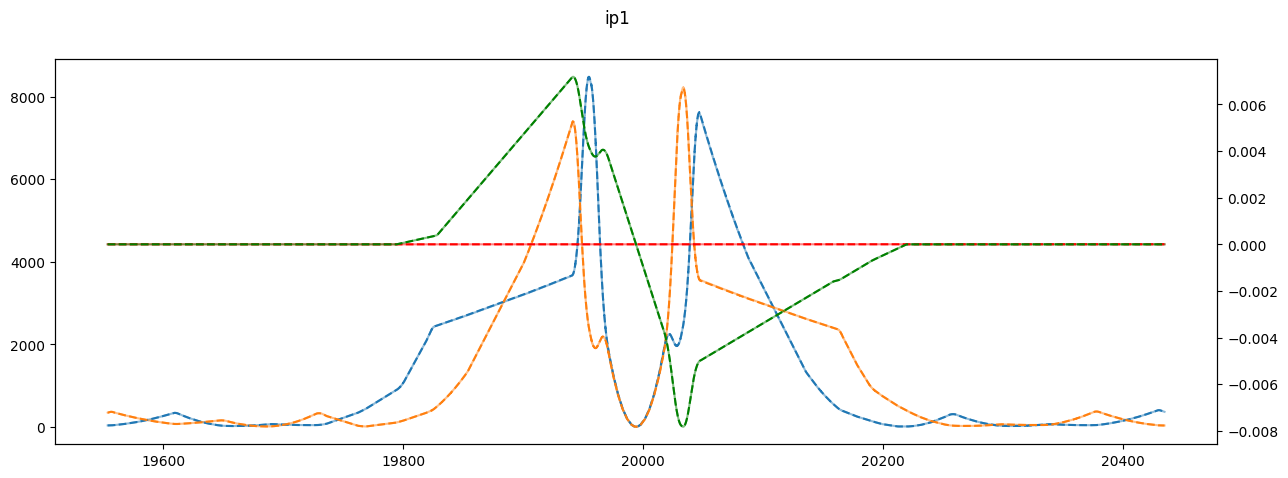

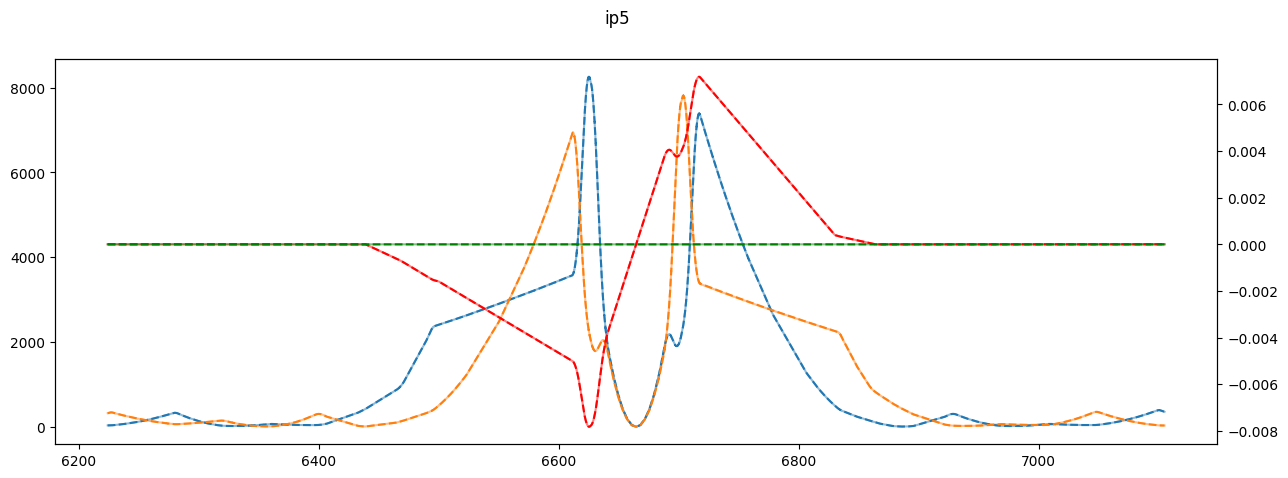

In [4]:

collider= power_BBCW(collider,config)
line    = collider['lhcb1']

tw     = line.twiss()
tw_ip1 = tw.rows['e.arc.81.b1':'s.arc.12.b1']
tw_ip5 = tw.rows['e.arc.45.b1':'s.arc.56.b1']
print(' ')
for _tw,_tw0,name in zip([tw_ip1,tw_ip5],[tw0_ip1,tw0_ip5],['ip1','ip5']):

    plt.figure(figsize=(15,5))
    plt.suptitle(name)
    plt.plot(_tw0.s, _tw0.betx,ls = '-',alpha=0.5,color='C0', label='betx')
    plt.plot(_tw0.s, _tw0.bety,ls = '-',alpha=0.5,color='C1', label='bety')
    plt.plot(_tw.s, _tw.betx,ls ='--',color='C0', label='betx')
    plt.plot(_tw.s, _tw.bety,ls ='--',color='C1', label='bety')
    plt.twinx()
    plt.plot(_tw0.s, _tw0.x,ls = '-',alpha=0.5,color='r', label='betx')
    plt.plot(_tw0.s, _tw0.y,ls = '-',alpha=0.5,color='g', label='bety')
    plt.plot(_tw.s, _tw.x,ls ='--',color='r', label='betx')
    plt.plot(_tw.s, _tw.y,ls ='--',color='g', label='bety')

In [6]:
opt

NameError: name 'opt' is not defined

In [5]:
beam_name = 'b1'
for ip in ['ip1','ip5']:
    for Q4_knob in [f'kq4.l{ip[-1]}{beam_name}', f'kq4.r{ip[-1]}{beam_name}']:
        print(Q4_knob,collider.vars[Q4_knob]._value)
        print(Q4_knob + '.k0',collider.vars[Q4_knob + '.k0']._value)

kq4.l1b1 0.003463379743422699
kq4.l1b1.k0 7.709856659675795e-09
kq4.r1b1 -0.0034924077788260934
kq4.r1b1.k0 -9.563266980894459e-09
kq4.l5b1 0.0034985667632535435
kq4.l5b1.k0 1.874804903007791e-08
kq4.r5b1 -0.003483009908887548
kq4.r5b1.k0 -1.3357109332941719e-09


In [5]:
beam_name = 'b1'
for ip in ['ip1','ip5']:
    for Q4_knob in [f'kq4.l{ip[-1]}{beam_name}', f'kq4.r{ip[-1]}{beam_name}']:
        print(Q4_knob,collider.vars[Q4_knob]._value)
        print(Q4_knob + '.k0',collider.vars[Q4_knob + '.k0']._value)

kq4.l1b1 0.0034633766881414416
kq4.l1b1.k0 7.745978078371144e-09
kq4.r1b1 -0.003492411712710084
kq4.r1b1.k0 -9.554282004319105e-09
kq4.l5b1 0.0034985624079598102
kq4.l5b1.k0 1.874162622179842e-08
kq4.r5b1 -0.003483013896151699
kq4.r5b1.k0 -1.334413337382634e-09


In [7]:
    config_bbcw = config['config_collider']['config_bbcw']

    for beam_name in ['b1','b2']:
        wire_dict = config_bbcw[f'{beam_name}'] 
        
        # Skip if not powered
        #--------------------------------
        if (wire_dict['ip1']['current'] == 0) and (wire_dict['ip5']['current'] == 0): 
            continue


        # Aligning the wires:
        #--------------------------------
        line    = collider[f'lhc{beam_name}']
        tw0     = line.twiss()
        target_co = []
        for _bbcw,_at in bbcw_insert[beam_name].items():
            ip      = 'ip' + _bbcw.split('.')[2][-1]
            tw_tct  = tw0.rows[_at]

            # updating knobs
            collider.vars[f'd_wire_{ip}.{beam_name}']    = wire_dict[ip]['distance']
            collider.vars[f'co_x_wire_{ip}.{beam_name}'] = tw_tct.x
            collider.vars[f'co_y_wire_{ip}.{beam_name}'] = tw_tct.y
            target_co.append(xt.TargetSet(  x = tw_tct.x[0],
                                            y = tw_tct.y[0], at=_at, tol=1e-6,tag=f'co_wire_{ip}'))
            

        # Preparing the matcher
        #--------------------------------
        # common_targets = target_co + [  xt.TargetSet(qx=tw0.qx, qy=tw0.qy, tol=1e-6, tag='tune'),
        #                                 xt.TargetSet(betx=tw0.rows['ip1'].betx[0], bety=tw0.rows['ip1'].bety[0],at='ip1', tol=1e-6, tag='betstar_ip1'),
        #                                 xt.TargetSet(betx=tw0.rows['ip5'].betx[0], bety=tw0.rows['ip5'].bety[0],at='ip5', tol=1e-6, tag='betstar_ip5')]
        
        common_targets = target_co + [  xt.TargetSet(qx=tw0.qx, qy=tw0.qy, tol=1e-6, tag='tune') ]
        opt = {}
        for ip in ['ip1','ip5']:
            opt[ip] = line.match(solve=False,
                                    vary    = [ xt.VaryList([f'kq4.l{ip[-1]}{beam_name}', f'kq4.r{ip[-1]}{beam_name}'], step=1e-8, tag=f'quad_{ip}'),
                                                xt.VaryList([f'kq4.l{ip[-1]}{beam_name}.k0', f'kq4.r{ip[-1]}{beam_name}.k0'], step=1e-8, tag=f'quad_k0_{ip}')],
                                    targets = common_targets)
            

        # Powering the wires one-by-one:
        #-----------------------------------
        for ip in ['ip1','ip5']:
            collider.vars[f'i_wire_{ip}.{beam_name}'] = wire_dict[ip]['current']

            # assert no change on closed orbit
            ttt = opt[ip].target_status(ret=True)
            assert np.all(ttt['tol_met'][[('co_wire' in t) for t in ttt['tag']]]), 'Wires seems misaligned!'

            # Matching
            opt[ip].solve()

Target status:                          
id state tag         tol_met      residue  current_val   target_val description                                 
 0 ON    co_wire_ip1    True -3.34299e-13  4.98304e-07  4.98304e-07 line=lhcb1, ('x', 'tctpv.4l1.b1'), val=4 ...
 1 ON    co_wire_ip1    True -1.19052e-10    0.0015875   0.00158751 line=lhcb1, ('y', 'tctpv.4l1.b1'), val=0 ...
 2 ON    co_wire_ip1    True -3.34299e-13  4.98304e-07  4.98304e-07 line=lhcb1, ('x', 'tctpv.4l1.b1'), val=4 ...
 3 ON    co_wire_ip1    True -1.19052e-10    0.0015875   0.00158751 line=lhcb1, ('y', 'tctpv.4l1.b1'), val=0 ...
 4 ON    co_wire_ip5    True -1.07823e-12  -0.00209608  -0.00209608 line=lhcb1, ('x', 'tctph.4l5.b1'), val=- ...
 5 ON    co_wire_ip5    True  2.93757e-10 -3.23478e-07 -3.23772e-07 line=lhcb1, ('y', 'tctph.4l5.b1'), val=- ...
 6 ON    co_wire_ip5    True -1.07823e-12  -0.00209608  -0.00209608 line=lhcb1, ('x', 'tctph.4l5.b1'), val=- ...
 7 ON    co_wire_ip5    True  2.93757e-10 -3.23478e-07 

In [15]:
{**opt['ip1'].get_knob_values(), **opt['ip5'].get_knob_values()}

{'kq4.l1b1': 0.0034633766881414416,
 'kq4.r1b1': -0.003492411712710084,
 'kq4.l1b1.k0': 7.745978078371144e-09,
 'kq4.r1b1.k0': -9.554282004319105e-09,
 'kq4.l5b1': 0.0034985624079598102,
 'kq4.r5b1': -0.003483013896151699,
 'kq4.l5b1.k0': 1.874162622179842e-08,
 'kq4.r5b1.k0': -1.334413337382634e-09}

In [18]:
collider.metadata

{'config_J000': {'save_collider': '/home/HPC/phbelang/abp/BBStudies/study_signature/colliders/collider_mad.json',
  'links': {'acc-models-lhc/optics': '../Machines/Optics',
   'acc-models-lhc/toolkit': '../Machines/Toolkit',
   'acc-models-lhc/sequences': '../Machines/Sequences'},
  'optics_file': 'acc-models-lhc/optics/opticsfile.32',
  'slice_factor': 4,
  'beam_config': {'lhcb1': {'beam_energy_tot': 6800},
   'lhcb2': {'beam_energy_tot': 6800}},
  'enable_imperfections': False,
  'enable_knob_synthesis': True,
  'rename_coupling_knobs': True,
  'ver_hllhc_optics': None,
  'ver_lhc_run': 3.0,
  'pars_for_imperfections': {'par_myseed': 1,
   'par_correct_for_D2': 0,
   'par_correct_for_MCBX': 0,
   'par_on_errors_LHC': 1,
   'par_off_errors_Q4_inIP15': 0,
   'par_off_errors_Q5_inIP15': 0,
   'par_on_errors_MBH': 1,
   'par_on_errors_Q4': 1,
   'par_on_errors_D2': 1,
   'par_on_errors_D1': 1,
   'par_on_errors_IT': 1,
   'par_on_errors_MCBRD': 0,
   'par_on_errors_MCBXF': 0,
   'par_on

In [22]:
{**opt['ip1'].get_knob_values(), **opt['ip5'].get_knob_values()}

{'kq4.l1b1': 0.0034633766881414416,
 'kq4.r1b1': -0.003492411712710084,
 'kq4.l1b1.k0': 7.745978078371144e-09,
 'kq4.r1b1.k0': -9.554282004319105e-09,
 'kq4.l5b1': 0.0034985624079598102,
 'kq4.r5b1': -0.003483013896151699,
 'kq4.l5b1.k0': 1.874162622179842e-08,
 'kq4.r5b1.k0': -1.334413337382634e-09}

In [26]:
(**opt[ip].get_knob_values() for ip in ['ip1','ip5'])

SyntaxError: invalid syntax (329683504.py, line 1)

In [20]:

# Loading collider and configs
#-------------------
config      = xutils.read_YAML(file=config_file )
config['from_collider'] = '/Users/pbelanger/ABPLocal/BBStudies/examples/run_xmask_jobs/colliders/collider_000.json'
# collider    = xt.Multiline.from_json(config['from_collider'])
# config_mad  = collider.metadata['config_J000']
# config_collider = config["config_collider"]
file = config['from_collider']
with open(file, 'r') as fid:
    dct = json.load(fid)

In [21]:
dct['metadata']

{'config_J000': {'save_collider': '/home/HPC/phbelang/abp/BBStudies/study_signature/colliders/collider_mad.json',
  'links': {'acc-models-lhc/optics': '../Machines/Optics',
   'acc-models-lhc/toolkit': '../Machines/Toolkit',
   'acc-models-lhc/sequences': '../Machines/Sequences'},
  'optics_file': 'acc-models-lhc/optics/opticsfile.32',
  'slice_factor': 4,
  'beam_config': {'lhcb1': {'beam_energy_tot': 6800},
   'lhcb2': {'beam_energy_tot': 6800}},
  'enable_imperfections': False,
  'enable_knob_synthesis': True,
  'rename_coupling_knobs': True,
  'ver_hllhc_optics': None,
  'ver_lhc_run': 3.0,
  'pars_for_imperfections': {'par_myseed': 1,
   'par_correct_for_D2': 0,
   'par_correct_for_MCBX': 0,
   'par_on_errors_LHC': 1,
   'par_off_errors_Q4_inIP15': 0,
   'par_off_errors_Q5_inIP15': 0,
   'par_on_errors_MBH': 1,
   'par_on_errors_Q4': 1,
   'par_on_errors_D2': 1,
   'par_on_errors_D1': 1,
   'par_on_errors_IT': 1,
   'par_on_errors_MCBRD': 0,
   'par_on_errors_MCBXF': 0,
   'par_on